# Galaxy cluster mass estimates using machien learning methods

This python notebook is meant to accompy Armitage et. al in prep. It contains a few example code snippits to introduce the reader to the python package sci-kit learn, and how to use sklearn to estimate the mass of galaxy clusters. If you find this notebook useful feel free to use parts of it in your own work and please cite Armitage et. al in prep, thank you!

## Setting up initial data

First import all the packages we shall be using

In [93]:
# Import standard packages
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'text.latex.preamble':[r"\usepackage{amsmath}"]})
# The example data file is pickled, not necessary for your own work
import pickle

# Import scikit learn
import sklearn as skl
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression


Then read in the example data

In [94]:
with open('ExampleGalaxyData.dat' , 'rb') as f:
    data=pickle.load(f)
f.close()

This is a pandas data frame containing a subset of the MACSIS clusters (Barnes et al. 2017) at $z=0.25$. The clusters are projected along a cylinder of length $10r_{200c}$, with an aperture of $1r_{200c}$. All galaxies within this cylinder above a stellar mass of $10^{10} \, \rm M_\odot$ are included and all clusters have at least 10 galaxies inside the cylinder.

The data is structured as follows:

In [95]:
data.head(2)

,M200,R200,posProj,velProj,massProj,RposProj,WL,M500,Xray,R500,sT500_CE,Ysz_5R500,Lb500_CE
hm,,,,,,,,,,,,,
0000,4.746686e+15,3.264318,"[[0.0, 0.0], [-0.1040420949031119, 0.971253299...","[98.07203674316406, 2734.514892578125, 2234.14...","[42108875695136.125, 657260405625.0404, 115079...","[0.0, 0.9768099758935769, 0.48081314504030453,...",6.166477e+15,3.510442e+15,2.222507e+15,1.867363,15.052479,0.001744,1.121513e+46
0001,1.654676e+15,2.297391,"[[0.0, 0.0], [0.08733142323575868, 1.421278952...","[724.2275390625, 930.0521850585938, 2905.94873...","[12544811350662.168, 1258760710917.9023, 43747...","[0.0, 1.4239594935696613, 1.2436218203732083, ...",9.209932e+14,9.705162e+14,5.512971e+14,1.173302,6.524063,0.000532,1.871028e+45


M200 and R200 are the mass and radius of the cluster in $\rm M_\odot$ and $\rm Mpc$ respectivly. The pos, vel, mass and Rpos 'proj' data are arrays of the projected positions $\rm [Mpc]$, velocities $\rm [km/s]$, stellar masses $\rm [M_\odot]$ and projected radial positions $\rm [Mpc]$ of the galaxies in each cluster.

The following data are not used explicitly in this notebook, but are included in case you wish to try out something extra. WL is the estimated weak lensing mass of the clusters, M500 the mass inside R500 and Xray is the hydrostatic mass estimate of $M_{500c} \, [\rm M_\odot]$. sT500_CE and Lb500_CE are the core-excised surface termperature and bolometric luminosity of the clusters inside $r_{500c}$ and Ysz_5R500 is the SZ flux inside $5r_{500c}$. These values are from Henson et al. 2017 and Barnes et al. 2017.

The index is the halo number and is a unique integer identifier of the cluster.

## Extracting features from the data
The machine learning technqies used in this work need to be individual floats (see [here](https://dougalsutherland.github.io/skl-groups/index.html) for a different implimentation which takes the whole distribution as a feature as used in Ntampaka et al. 2015).

Here we shall extract the mean, standard error on the mean, standard deviation, skewness and kurtosis of the galaxy velocity, mass and position distributions of each cluster as well as the number of galaxies.

In [96]:
def FeatureCreation(df,spectroscopic=True,Ngal=True):
    # The purpose of this function is the take the galaxy data of each MACSIS
    # cluster and create a set of features, which can then be fed into sklearn
    # regression algorithms
    featDf=pd.DataFrame()

    # Features to extract
    fname=['kurt','skew','sem','std','mean']
    spsFuncs=[sps.kurtosis,sps.skew,sps.sem,np.std,np.mean]
        
    abbrvNames={'RposProj':'Rpos','massProj':'mass'}

    # Add in velocity infomation if the data set is spectroscopic
    if spectroscopic==True:
        abbrvNames['velProj']='vel'

    for idx,func in enumerate(spsFuncs):
        tmpDf=df['posProj'].apply(func,args=(0,))
        tmpDf=tmpDf.apply(pd.Series)
        featDf['X_'+fname[idx]]=tmpDf[0]
        featDf['Y_'+fname[idx]]=tmpDf[1]

    for key in abbrvNames.keys():
        for idx,func in enumerate(spsFuncs):
            tmpDf=df[key].apply(func)
            # Take the log of the velocity dispersion as it 
            # scales M \propto \sigma^3
            if (abbrvNames[key]=='vel')&(fname[idx]=='std'):
                featDf[abbrvNames[key]+'_'+fname[idx]]=np.log10(tmpDf)
            else:
                featDf[abbrvNames[key]+'_'+fname[idx]]=tmpDf

    # Log of the number of galaxies in the cluster
    if Ngal==True:
        featDf['LogNgal']=np.log10(df['massProj'].apply(len))

    return featDf

In [97]:
featDf=FeatureCreation(data,spectroscopic=True)

print('Number of features: ',len(featDf.keys()))
print(featDf.keys())

Number of features:  26
Index(['X_kurt', 'Y_kurt', 'X_skew', 'Y_skew', 'X_sem', 'Y_sem', 'X_std',
       'Y_std', 'X_mean', 'Y_mean', 'Rpos_kurt', 'Rpos_skew', 'Rpos_sem',
       'Rpos_std', 'Rpos_mean', 'mass_kurt', 'mass_skew', 'mass_sem',
       'mass_std', 'mass_mean', 'vel_kurt', 'vel_skew', 'vel_sem', 'vel_std',
       'vel_mean', 'LogNgal'],
      dtype='object')


Many machine learning algorithms assume that the features are centred around 0 with a width of $\mathcal{O}(1)$. We scale the data by dividing by the 68% spread and subtracting the median.

In [98]:
X=featDf.values
X = RobustScaler().fit_transform(X)

X now contains a N features for each cluster. We also need a feature that we will train our model to reproduce. In this case it will simply be the mass of the cluster logged, $\log M_{200c}$.

In [99]:
LogM200=np.log10(data.M200.values)

## Feature elimination
Some of the features generated will contain little useful information regarding $M_{200c}$. We can use recursive feature elimination to get rid unhelpful features.

In [100]:
def REF_Only(X,y,score='r2'):
    # This estimator could be changed easily to give better results
    #estimator = SVR(kernel="linear")
    estimator = LinearRegression()
    #estimator = Ridge()

    # Possible regression scorers 
    #['r2','neg_median_absolute_error','neg_mean_absolute_error']
    
    selector = RFECV(estimator, step=1, cv=5,scoring=score)

    selector = selector.fit(X, y)
    # X_new contains only the best features
    X_rfe = selector.fit_transform(X, y)

    return X_rfe,selector.ranking_,selector.grid_scores_

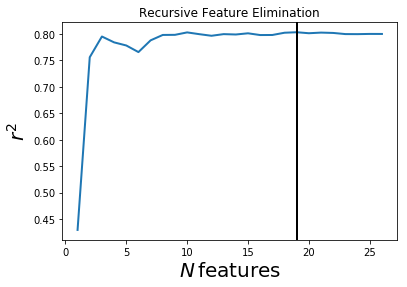

In [101]:
X_rfe,ranking,grid_scores=REF_Only(X,LogM200,score='r2')

#Plot the regressor score against number of features
plt.plot(np.arange(len(grid_scores))+1,grid_scores,lw=2)
plt.axvline(np.argmax(grid_scores)+1,lw=2,c='k')
plt.xlabel('$N \, \mathrm{features}$',fontsize=20)
plt.ylabel('$r^2$',fontsize=20)
plt.title('Recursive Feature Elimination')
plt.show()

We have marked the maximum value of $r^2$ on the plot above, the curve is relativly flat beyond 10 features, but peaks at 19. These 19 features are what is returned as X_rfe.

## Training the model
Finally we are ready to train the regression model. As per Armitage et al. in prep we shall use ridge regression, though it is relativly simple to replace with whatever model you desire in sklearn, you can change the 'model' keyword to 'OLR' or 'KRR' for ordinary linear regression and kernal ridge regression respectivly. This function also tunes any hyper-parameters using the GridSearchCV method.

In [102]:
def SplitAndTrain(X,y,splits,model='OLR'):
    #y_pred is log_10 masses
    kf=KFold(n_splits=splits, random_state=3, shuffle=True)

    allRatios=np.array([])

    # Predected values of y
    y_pred_Arr=np.ones(len(y))+np.nan

    # Split the data into random 'splits'. Shuffle round to always
    # test on one and train on the rest.
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Now that I have my training and testing datasets train a 
        # given model.
        if model=='KRR':
            mod_clf = GridSearchCV(
                        KernelRidge(kernel='rbf', gamma=0.1),
                        cv=5,
                        param_grid={
                                "alpha": [1e0, 0.1, 1e-2, 1e-3],
                                "gamma": np.logspace(-2, 2, 5)
                                })
            y_pred = mod_clf.fit(X_train, y_train).predict(X_test)

        elif model=='OLR':
            mod_clf = LinearRegression(fit_intercept=True)
            mod_clf.fit(X_train, y_train)
            y_pred=mod_clf.predict(X_test)
            

        elif model=='Ridge':
            mod_clf=GridSearchCV(Ridge(fit_intercept=True), cv=5,
                       param_grid={"alpha": np.linspace(0.1,9.1,21),
                                   })
            mod_clf.fit(X_train, y_train)
            y_pred=mod_clf.predict(X_test)

        y_pred_Arr[test_index]=y_pred

    return mod_clf,y_pred_Arr

In [103]:
trainedModel,LogM200_pred=SplitAndTrain(X_rfe,LogM200,splits=10,model='Ridge')

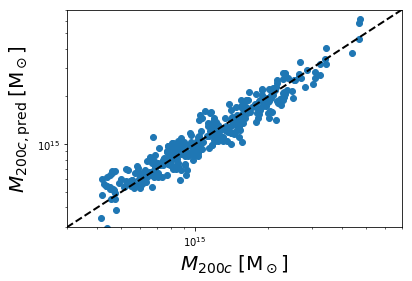

In [104]:
# Plot the predicted mass vs true

plt.loglog(10**LogM200,10**LogM200_pred,'o')

plt.xlim([3e14,7e15])
plt.ylim([3e14,7e15])
plt.plot([3e14,1e16],[3e14,1e16],'--k',lw=2)

plt.xlabel('$M_{200c} \; \\rm [M_\odot]$',fontsize=20)
plt.ylabel('$M_{200c, \\rm pred} \; \\rm [M_\odot]$',fontsize=20)
plt.show()

### Comparison to just using the velocity dispersion
This is just a quick comparison to show using only one feature, the velocity dispersion, to train the model

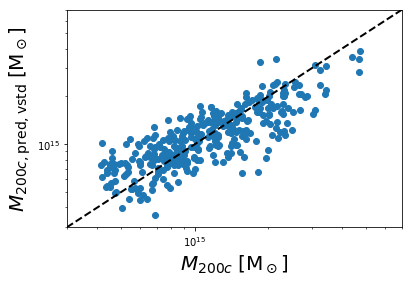

In [105]:
vel_stdOnly=featDf[['vel_std']].values
vel_stdOnly = RobustScaler().fit_transform(vel_stdOnly)
trainedModel_vstd,LogM200_vstd=SplitAndTrain(vel_stdOnly,LogM200,splits=10,model='Ridge')

plt.loglog(10**LogM200,10**LogM200_vstd,'o')
plt.xlim([3e14,7e15])
plt.ylim([3e14,7e15])
plt.plot([3e14,1e16],[3e14,1e16],'--k',lw=2)
plt.xlabel('$M_{200c} \; \\rm [M_\odot]$',fontsize=20)
plt.ylabel('$M_{200c, \\rm pred, vstd} \; \\rm [M_\odot]$',fontsize=20)
plt.show()